# Demographic and clinical characteristics of cohort

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

Associations of categorical demographic and clinical characteristics with TB disease manifestations were assessed by chi-squared test or Fisher's exact test if expected frequencies were below five. Associations with continuous variables were assessed by student t-tests. Single test significance level was Bonferroni adjusted for multiple comparisons.

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-16


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(data.table)
library(repr)
library(memisc)
library(xtable)
library(dplyr)
library(Table1)
library(xtable)
library(htmlTable)
library(ggplotify)
library(RColorBrewer)
library(grid)
library(gridExtra)

options("width"=200)

In [5]:
%%bash
mkdir -p ./reports/tables

## 1. Import files

## 1.1 Clinical and demographic data of TB patients

In [6]:
%%R
# Load clinical data
patients_clinical_data_file <- "./data/raw/metadata/host_metadata.tsv"
sample_metadata <- read.table(patients_clinical_data_file, header=TRUE, sep='\t', 
                                     stringsAsFactors=FALSE, row.names=1, na.strings=c('unknown',''))
head(sample_metadata, n=3)

# Define levels and labels for categorical variables:
sample_metadata$smear_grading_bin <- factor(sample_metadata$smear_grading_bin, levels=c('Low','High'))

xraysevere.levels                 <- c("Normal", "Mild/moderate", "Severe")
sample_metadata$xraysevere        <- factor(sample_metadata$xraysevere, 
                                            levels = xraysevere.levels, ordered=TRUE)

tbscore_bin.levels                <- c("Mild", "Severe")
sample_metadata$tbscore_bin       <- factor(sample_metadata$tbscore_bin, 
                                            levels = tbscore_bin.levels, ordered=TRUE)

age.levels                        <- c("<25", "25-34", "35-44", ">44")
sample_metadata$age_cat           <- factor(sample_metadata$age_cat, levels=age.levels)

sex.levels                        <- c("male","female")
sex.labels                        <- c("Male","Female")
sample_metadata$male              <- factor(sample_metadata$male, levels = sex.levels, labels=sex.labels)

bmi_cat.levels                    <- c("BMI >=18.5", "BMI <18.5")
bmi_cat.labels                    <- c("Normal/Obese BMI>=18.5", "Underweight BMI<18.5")
sample_metadata$bmi_cat           <- factor(sample_metadata$bmi_cat, 
                                            levels = bmi_cat.levels, labels = bmi_cat.labels)

season.levels                     <- c("Short Rain", "Long Rain", "Dry")
season.labels                     <- c("Short Rains (Oct. - Feb.)", "Long Rains (March - May)", "Dry (June - Sept.)")
sample_metadata$season            <- factor(sample_metadata$season, levels = season.levels, 
                                            labels = season.labels)

cavitation.levels           <- c("no","yes")
cavitation.labels           <- c("Absent","Present")
sample_metadata$caviation   <- factor(sample_metadata$caviation, 
                                      levels=cavitation.levels, labels=cavitation.labels,
                                      ordered=FALSE)

infiltration.levels           <- c("no","yes")
infiltration.labels           <- c("Absent","Present")
sample_metadata$filtration   <- factor(sample_metadata$filtration, levels=infiltration.levels, 
                                       labels=infiltration.labels,
                                       ordered=FALSE)

effusion.levels           <- c("no","yes")
effusion.labels           <- c("Absent","Present")
sample_metadata$effusion   <- factor(sample_metadata$effusion, levels=effusion.levels, 
                                       labels=effusion.labels,
                                       ordered=FALSE)

lymphnode.levels           <- c("no","yes")
lymphnode.labels           <- c("Absent","Present")
sample_metadata$lymphnode   <- factor(sample_metadata$lymphnode, levels=lymphnode.levels, 
                                       labels=lymphnode.labels,
                                       ordered=FALSE)

micronode.levels           <- c("no","yes")
micronode.labels           <- c("Absent","Present")
sample_metadata$micronode   <- factor(sample_metadata$micronode, levels=micronode.levels, 
                                       labels=micronode.labels,
                                       ordered=FALSE)

# Create lineage variable that excludes L2 (too few numbers)
#-----------------------------------------------------------
sample_metadata$lineage134 <- sample_metadata$lineage
sample_metadata$lineage134[sample_metadata$lineage134 == 'L2'] <- NA
sample_metadata$lineage134 <- factor(sample_metadata$lineage134, levels=c('L3','L1','L4'))

**Re-define levels for medications taken**

In [7]:
%%R
sample_metadata$delaymedtp_agr[sample_metadata$delaymedtp_agr == 'no'] <- NA
delaymedtp_agr_levels <- c('penicillins','ciprofloxacin','cefalexin',
                           'penicillins+ciprofloxacin', 
                           'penicillins+chloramphenicol','penicillins+cefalexin',
                           'penicillins+chloramphenicol+ciprofloxacin','penicillins+ciprofloxacin+cefalexin', 
                           'others')
sample_metadata$delaymedtp_agr = factor(sample_metadata$delaymedtp_agr, levels=delaymedtp_agr_levels)

# Define a more granulated and balanced distribution of medications
# combine rare medications (freq <= 7) into single category (other-medications)
medications_freq_table <- table(sample_metadata$delaymedtp_cat)
rare_medications <- row.names(medications_freq_table[medications_freq_table <= 7])
sample_metadata$delaymedtp_cat2 <- sapply(as.vector(sample_metadata$delaymedtp_cat), 
                                          function(x){if(x %in% rare_medications){'other-medications'}else{x}})
delaymedtp_cat2_levels <- c('no','amoxycillin','amoxycillin+ampicillin','amoxycillin+cloxacillin',
                            'amoxycillin+ampicillin+cloxacillin','other-medications')
sample_metadata$delaymedtp_cat2 <- factor(sample_metadata$delaymedtp_cat2, levels=delaymedtp_cat2_levels)

#table(sample_metadata$delaymedtp_cat2)

sample_metadata$delaymed_3cat <- plyr::mapvalues(sample_metadata$delaymedtp_cat2, 
                                              from=delaymedtp_cat2_levels, 
                                              to=c('No','Penicillins','Penicillins','Penicillins',
                                                   'Penicillins','Other'))

**Define levels for Anemia status**

Based on Hemoglobin levels, we followed the World Health Organization (WHO) criteria to define anemia for:

- Women:
  - no anemia: >=12 g/dL
  - mild anemia: 11 - 11.9 g/dL
  - moderate anemia: 8.0 - 10.9
  - severe anemia: < 8.0
- Men:
  - no anemia: >=13 g/dL
  - mild anemia: 11 - 12.9 g/dL
  - moderate anemia: 8.0 - 10.9
  - severe anemia: < 8.0

In [8]:
%%R
anemia_status <- rep(NA, dim(sample_metadata)[1])
anemia_status[(sample_metadata$male == "Male") & (sample_metadata$hblevel >=13)] <- 'No anemia'
anemia_status[(sample_metadata$male == "Male") & 
              (sample_metadata$hblevel >=11 & sample_metadata$hblevel <=12.9)] <- 'Mild'

anemia_status[(sample_metadata$male == "Female") & (sample_metadata$hblevel >=12)] <- 'No anemia'
anemia_status[(sample_metadata$male == "Female") & 
              (sample_metadata$hblevel >=11 & sample_metadata$hblevel <=11.9)] <- 'Mild'

anemia_status[(sample_metadata$hblevel >=8.0) & (sample_metadata$hblevel <=10.9)] <- 'Moderate'
anemia_status[sample_metadata$hblevel <=7.9] <- 'Severe'

anemia_levels <- c('No anemia','Mild','Moderate','Severe')
sample_metadata$anemia_status <- factor(anemia_status, levels=anemia_levels, ordered=TRUE)
sample_metadata$anemia_bin <- plyr::mapvalues(sample_metadata$anemia_status, 
                                              from=anemia_levels, 
                                              to=c('No','Yes','Yes','Yes'))
table(sample_metadata$anemia_bin)


 No Yes 
 81 235 


**Define levels of nutritional status**

We followed the WHO criteria to define nutritional status based on BMI values:
- Underweight: <18.5
- Normal weight: 18.5 - 24.9
- Obesity: >=25

In [9]:
%%R
nutritional_status <- rep(NA, dim(sample_metadata)[1])
nutritional_status[sample_metadata$bmi < 18.5] <- 'Underweight'
nutritional_status[(sample_metadata$bmi >= 18.5) & (sample_metadata$bmi < 25)] <- 'Normal weight'
nutritional_status[sample_metadata$bmi >= 25] <- 'Obesity'
nutritional_status_levels <- c('Normal weight','Underweight','Obesity')
sample_metadata$nutrition_status <- factor(nutritional_status, levels=nutritional_status_levels, 
                                           ordered=FALSE)
table(sample_metadata$nutrition_status)


Normal weight   Underweight       Obesity 
          145           176            13 


**Define binary categorization of chest X-ray findings**

In [10]:
%%R
# Create variable to resgister X-ray findings as Normal or Abnormal
#------------------------------------------------------------------
xray_findings <- as.vector(sample_metadata$xraysevere)
#xray_findings[is.na(sample_metadata$xraysevere)] <- "Missing"
xray_findings[xray_findings=="Mild/moderate"] <- "Abnormal"
xray_findings[xray_findings=="Severe"] <- "Abnormal"
sample_metadata$xray_findings <- factor(xray_findings, levels=c("Normal","Abnormal"))
table(sample_metadata$xray_findings)
# One sample H00086 was mistakenly label as Normal
sample_metadata['H00086','xray_findings'] <- 'Abnormal'

table(sample_metadata$xray_findings)


  Normal Abnormal 
      58      189 


**Define categories for chest x-ray findings, according to type of lesions:**

Abnormal CXRs in this TB cohort comprised five types of CXR signs: 
 - parenchymal lesions (infiltrates/consolidations), 
 - cavities, 
 - pleural effusion, 
 - lymphadenopathy, and 
 - micronodules. 
 
The lungs of a single TB patient might be affected by different types of lesions as the disease progresses, as seen in the Venn diagram shown below:

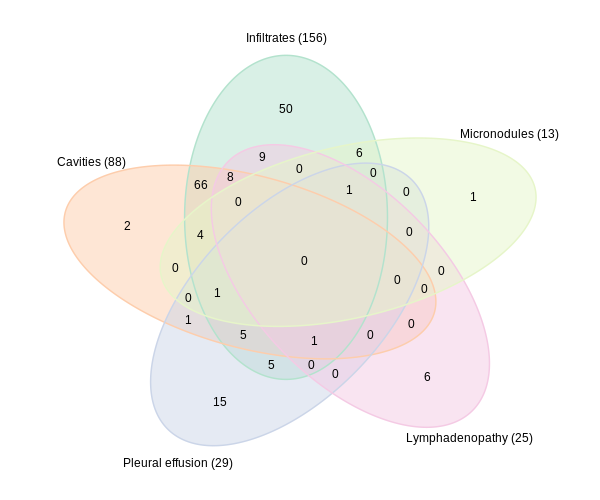

In [11]:
%%R -w 600 -h 500 -u px

set_infiltration <- unique(rownames(subset(sample_metadata, filtration=='Present')))
set_cavitation <- unique(rownames(subset(sample_metadata, caviation=='Present')))
set_micronodules <- unique(rownames(subset(sample_metadata, micronode=='Present')))
set_pleuraleffusion <- unique(rownames(subset(sample_metadata, effusion=='Present')))
set_linphnode <- unique(rownames(subset(sample_metadata, lymphnode=='Present')))

cxr_list <- list(set_infiltration, set_cavitation, set_pleuraleffusion, set_linphnode, set_micronodules)
cxr_names <- c("Infiltrates", "Cavities", "Pleural effusion", "Lymphadenopathy", "Micronodules")
cxr_labels <- paste0(cxr_names,' (', unlist(lapply(cxr_list, length)),')')

myCol <- brewer.pal(5, "Pastel2")
cxr_findings_venn <- VennDiagram::venn.diagram(cxr_list, 
                                               category.names = cxr_labels, 
                                               fill = myCol,
                                               col = myCol,
                                               cat.pos=c(0,-25,-150,150,25),
                                               margin = 0.1, 
                                               cat.fontfamily = "sans",
                                               fontfamily="sans",
                                               filename=NULL)
grid.draw(cxr_findings_venn)

Parenchymal lesions were the most frequent (63.3\%, n=156)) type of CXR signs in this cohort and were present alone (32\%, n=50) or together with the other CXR signs, as shown in the Venn diagram below. For instance, 85 out of the 88 (97\%) patients with lung cavities had also parenchymal lesions. To further characterize the association of abnormal CXRs with differences in microbial community composition and diversity, we re-categorized abnormal CXRs into 5 groups:

 1. parenchymal lesions (only), no additional CXR signs; 
 2. parenchymal lesions with cavities but no additional CXR signs; 
 3. parenchymal lesions and other, where 'other' refers to any additional CXR sign accompanied or not by cavities; 
 4. pleural effusion (only), no additional lesions; and 
 5. other, which aggregates patients without parenchymal lesions and one patient with pleural effusion and cavities.


In [12]:
%%R

# Re-categorize CXR findings:
#-----------------------------
cxr_categories <- as.vector(sample_metadata$xray_findings)

is_effusion_only <- with(sample_metadata, 
                         effusion=='Present' & filtration=='Absent' & caviation=='Absent' & lymphnode=='Absent' & micronode=='Absent')
cxr_categories[is_effusion_only] <- "effusion"

is_infiltration_only <- with(sample_metadata, 
                             filtration=='Present' & effusion=='Absent' & caviation=='Absent' & lymphnode=='Absent' & micronode=='Absent')
cxr_categories[is_infiltration_only] <- "filtration"

is_infiltr_cavit_only <- with(sample_metadata, 
                              filtration=='Present' & caviation=='Present' & effusion=='Absent' & lymphnode=='Absent' & micronode=='Absent')
cxr_categories[is_infiltr_cavit_only] <- "filtration_cavitation"

is_infiltrate_other <- (with(sample_metadata, filtration=='Present') & 
                        !(is_infiltration_only | is_infiltr_cavit_only))
cxr_categories[is_infiltrate_other] <- "filtration_other"

is_other <- (sample_metadata$xray_findings == "Abnormal" & 
             !(with(sample_metadata, filtration=='Present') | is_effusion_only))
cxr_categories[is_other] <- "other"

sample_metadata$cxr_categories <- factor(cxr_categories, 
                                         levels=c("Normal","filtration","filtration_cavitation","filtration_other","effusion","other"), 
                                         labels=c("Normal","Infiltration","Infiltration & Cavitation","Infiltration (other)","Pleural effusion","Other"))
print(table(sample_metadata$cxr_categories))

cat("\n Number of TB patients in dataset: ")
cat(dim(sample_metadata)[1])
cat("\n Number of variables in dataset: ")
cat(dim(sample_metadata)[2])


                   Normal              Infiltration Infiltration & Cavitation      Infiltration (other)          Pleural effusion                     Other 
                       58                        50                        66                        40                        15                        18 

 Number of TB patients in dataset: 334
 Number of variables in dataset: 77

We save the extened table with clinical metadata for each TB patient:

In [13]:
%%R
sample_metadata_extended_file <- "./data/interim/host_metadata_extended.tsv"
write.table(sample_metadata, sample_metadata_extended_file, sep="\t", row.names=TRUE)

In [14]:
!head -n 3 "./data/interim/host_metadata_extended.tsv"

"smear_grading"	"smear_grading_bin"	"tbscore_bin"	"tbscore"	"xraysevere"	"filtration"	"caviation"	"micronode"	"effusion"	"lymphnode"	"delaymed"	"tbdelay"	"male"	"age"	"bmi"	"bmi_cat"	"hblevel"	"cd4count"	"hiv"	"whohivstage"	"bacterial"	"strepto"	"legionella"	"heamophilus"	"mycoplasma"	"pertusis"	"chlamydophila"	"viral"	"hrv"	"fluA"	"fluB"	"AdV"	"rsvA"	"rsvB"	"piv4"	"oc43"	"hboV"	"nl63"	"hev"	"mpv"	"piv2"	"piv3"	"corona229e"	"helminth"	"ascaris"	"trichuris"	"hookworm"	"hymenana"	"diminuta"	"vermi"	"strongy"	"mansoni"	"hematobium"	"schisto"	"smoking"	"smokingdur"	"ciganumber"	"alcoholabuse"	"age_cat"	"hblevel_cat"	"date_enrolled"	"season"	"statart"	"previous_art"	"cd4count_cat"	"lineage"	"delaymedtp_cat"	"delaymedtp_agr"	"resprate"	"lineage134"	"delaymedtp_cat2"	"delaymed_3cat"	"anemia_status"	"anemia_bin"	"nutrition_status"	"xray_findings"	"cxr_categories"
"H00084"	"2+"	"High"	"Mild"	4	NA	NA	NA	NA	NA	NA	"yes"	"Delay <= 3 weeks"	"Male"	34	21.700918	"Normal/Obese BMI>=18.5"	NA	259	"positi

## 2. Characteristics of TB patients and associations with disease manifestations

### 2.1 Overall characteristics of TB patients

In [15]:
%%R
# Continous variables to include in table
continous_main_vars <- c("age","bmi","hblevel","resprate","ciganumber")
continous_main_headers <- c("Age (years)", "BMI (kg/m2)", "Hemoglobin (g/dL)", "Respiration rate (breaths/min)", 
                            "Cigarettes per day")
continous_main_tests <- c("ttest","ttest","ttest","ttest","wilcox")
continous_main_rmstat <- replicate(5,c("meansd","q1q3","minmax"),simplify=FALSE)

factors_main_vars <- c("male","nutrition_status","anemia_bin", 
                       "hiv","cd4count_cat","viral","bacterial", "helminth",
                       "smoking","alcoholabuse","season","previous_art",
                       "lineage","tbdelay","delaymed_3cat")
factors_main_headers <- c("Sex","Nutritional status","Anemia status", 
                          "HIV","CD4+ T cell counts (cells/ul)",
                          "Respiratory viruses","Respiratory bacteria","Helminths",
                          "Smoker","Alcohol abuse","Season","Previous ART",
                          "Mtb lineage","TB Diagnostic delay", "Non-TB medication")
factors_main_tests <- c("chisq","chisq","chisq","chisq",
                        "chisq","chisq","chisq","chisq","chisq",
                        "chisq","chisq","chisq",
                        "chisq","chisq","chisq")

order_main_vars <- c("male","age","bmi","nutrition_status","hblevel","anemia_bin","resprate",
                     "hiv","cd4count_cat","previous_art","viral","bacterial","helminth",
                     "smoking","ciganumber","alcoholabuse","season",
                     "lineage","tbdelay","delaymed_3cat")
table1_demographics_overall <- make.table(dat = sample_metadata[,c("xray_findings", order_main_vars)], 
                                          cat.varlist = factors_main_vars, 
                                          cat.header = factors_main_headers,
                                          cat.rmstat = list("row"),
                                          cont.varlist = continous_main_vars, 
                                          cont.header = continous_main_headers, 
                                          cont.rmstat = continous_main_rmstat, 
                                          vspace = FALSE)

                             Variable       Overall
 Sex                                               
   Count                                        334
   (%)                                             
   Male                                240 (71.86%)
   Female                               94 (28.14%)
   Missing                                        0
                                                   
 Age (years)                                       
    Count                                       334
    Median (IQR)                      33.00 (14.00)
    Missing                                       0
                                                   
 BMI (kg/m2)                                       
    Count                                       334
    Median (IQR)                       18.26 (3.85)
    Missing                                       0
                                                   
 Nutritional status                                
   Count    

### 2.2 Characteristics of TB patients by categories of TB disease manifestations

**By Mycobacterial load in sputum**

In [16]:
%%R
table1_demographics_bymtbload <- make.table(dat = sample_metadata[,c("smear_grading_bin", order_main_vars)], 
                                            strat = c("smear_grading_bin"),
                                            cat.varlist = factors_main_vars, 
                                            cat.header = factors_main_headers,
                                            cat.ptype = factors_main_tests,
                                        cat.rmstat = list("row"),
                                        cont.varlist = continous_main_vars, 
                                        cont.header = continous_main_headers,
                                        cont.ptype = continous_main_tests, 
                                        cont.rmstat = continous_main_rmstat, 
                                        vspace = FALSE)

                             Variable           Low          High       Overall           p.value
 Sex                                                                                        0.660
   Count (%)                           127 (38.02%)  207 (61.98%)           334        Chi-square
   (Col %)                                                                                       
   Male                                 89 (70.08%)  151 (72.95%)  240 (71.86%)                  
   Female                               38 (29.92%)   56 (27.05%)   94 (28.14%)                  
   Missing                                        0             0             0                  
                                                                                                 
 Age (years)                                                                                0.434
    Count                                       127           207           334            t-test
    Median (IQR)    

**By severity clinical findings (signs and symptoms)**

In [17]:
%%R
table1_demographics_tbscore <- make.table(dat = sample_metadata[,c("tbscore_bin", order_main_vars)], 
                                        strat = c("tbscore_bin"),
                                        cat.varlist = factors_main_vars, 
                                        cat.header = factors_main_headers,
                                        cat.ptype = factors_main_tests,
                                        cat.rmstat = list("row"),
                                        cont.varlist = continous_main_vars, 
                                        cont.header = continous_main_headers,
                                        cont.ptype = continous_main_tests, 
                                        cont.rmstat = continous_main_rmstat, 
                                        vspace = FALSE)

                             Variable          Mild        Severe       Overall           p.value
 Sex                                                                                        0.559
   Count (%)                           223 (66.77%)  111 (33.23%)           334        Chi-square
   (Col %)                                                                                       
   Male                                163 (73.09%)   77 (69.37%)  240 (71.86%)                  
   Female                               60 (26.91%)   34 (30.63%)   94 (28.14%)                  
   Missing                                        0             0             0                  
                                                                                                 
 Age (years)                                                                                0.159
    Count                                       223           111           334            t-test
    Median (IQR)    

**By Chest X-ray findings**

In [18]:
%%R
table1_demographics_bycxr <- make.table(dat = sample_metadata[,c("xray_findings", order_main_vars)], 
                                        strat = c("xray_findings"),
                                        cat.varlist = factors_main_vars, 
                                        cat.header = factors_main_headers,
                                        cat.ptype = factors_main_tests,
                                        cat.rmstat = list("row"),
                                        cont.varlist = continous_main_vars, 
                                        cont.header = continous_main_headers,
                                        cont.ptype = continous_main_tests, 
                                        cont.rmstat = continous_main_rmstat, 
                                        vspace = FALSE)

[1] "Total observations removed from table: 87"
[1] "Summary of total missing stratification variable(s):"
$xray_findings
[1] 87

                             Variable        Normal      Abnormal       Overall           p.value
 Sex                                                                                        0.646
   Count (%)                            58 (23.48%)  189 (76.52%)           247        Chi-square
   (Col %)                                                                                       
   Male                                 38 (65.52%)  132 (69.84%)  170 (68.83%)                  
   Female                               20 (34.48%)   57 (30.16%)   77 (31.17%)                  
   Missing                                        0             0             0                  
                                                                                                 
 Age (years)                                                                          

### 2.3 Combine tables for manuscript

In [19]:
%%R -o table1_demographics

demographics_caption <- "Characteristics of TB patients and associations with disease manifestations"

table1_demographics <- xtable(cbind(Variable=table1_demographics_overall$Variable, 
                                    Total=table1_demographics_overall$Overall,
                                    'Mycobacterial load'=table1_demographics_bymtbload[,-c(1,4)],
                                    'Clinical findings'=table1_demographics_tbscore[,-c(1,4)],
                                    'CXR findings'=table1_demographics_bycxr[,-c(1,4)]
                                   ), caption=demographics_caption)

demographics_comment <- paste0("\\multicolumn{",ncol(table1_demographics),
                               "}{p{1.85\\linewidth}}{\\rule{0em}{2.5ex} ",
                               "$^a$Student t-test if continuous variable, a Chi-squared test otherwise.",
                               " In bold, values below Bonferroni-adjusted significance criteria",
                               " ($\\alpha = 0.05/",length(order_main_vars),"$);",
                               " $^b$ Anyplex$^{TM}$ II RV16 and Allplex$^{TM}$ Respiratory Panel 4, Seegene.",
                               " 16 respiratory viruses and 6 bacterial species;",
                               " $^c$ 8 helminth parasites: \\textit{Ascaris lumbricoides},",
                               " \\textit{Enterobius vermicularis}, hookworm, \\textit{Hymenolepis diminuta}, ",
                               "\\textit{Schistosoma haematobium}, \\textit{Schistosoma mansoni}, ",
                               "\\textit{Strongyloides stercoralis} and \\textit{Trichuris trichiura}; ",
                               "$^d$ Mycobacterial load in the lungs was derived from Acid-Fast Bacilli (AFB) ",
                               "sputum smear grading (scanty, 1+, 2+, 3+) and categorized into 'Low' (scanty or 1+) ",
                               "and 'High' (2+ or 3+); $^e$ Duration of diagnostic delay was calculated based",
                               " on the longest reported TB-related symptom and categorized into: '$\\leq$3 weeks'",
                               " and '$>$3 weeks'; PTB, pulmonary tuberculosis}\\\\")

comment <- list(pos=list(0), command=NULL)
comment$pos[[1]] <- c(nrow(table1_demographics))
comment$command <- c(demographics_comment)

table1_demographics_file <- './reports/tables/decription_disease_manifestations.tex'
print(table1_demographics, include.rownames = FALSE, file=table1_demographics_file, caption.placement="top", 
      add.to.row=comment)

## 3. Distribution of chest X-ray lesion types by TB disease manifestations and associations among TB disease manifestations

### 3.1 Overall distribution of chest X-ray lesion types

In [20]:
%%R
tb_related_factors <- c("smear_grading_bin","tbscore_bin","xray_findings",
                        "filtration", "caviation", "effusion", "lymphnode", "micronode")
tb_related_factors_headers <- c("Mycobacterial load","Clinical findings","CXR findings",
                                "Lung infiltrates","Lung cavities",
                                "Pleural effusion","Lymphadenopathy","Micronodules")
factors_main_tests <- c("chisq","chisq","chisq",
                        "chisq","chisq","chisq","chisq","chisq")
table2_tbfeatures <- make.table(dat = sample_metadata[,tb_related_factors], 
                                cat.varlist = tb_related_factors, 
                                cat.header = tb_related_factors_headers,
                                cat.rmstat = list("row"),
                                vspace = FALSE)

                 Variable      Overall
 Mycobacterial load                   
   Count                           334
   (%)                                
   Low                    127 (38.02%)
   High                   207 (61.98%)
   Missing                           0
                                      
 Clinical findings                    
   Count                           334
   (%)                                
   Mild                   223 (66.77%)
   Severe                 111 (33.23%)
   Missing                           0
                                      
 CXR findings                         
   Count                           247
   (%)                                
   Normal                  58 (23.48%)
   Abnormal               189 (76.52%)
   Missing                          87
                                      
 Lung infiltrates                     
   Count                           247
   (%)                                
   Absent                

### 3.2 Distribution of chest x-ray lesion types by mycobacterial load in sputum

In [21]:
%%R

table2_tbfeatures_mtbload <- make.table(dat = sample_metadata[,tb_related_factors], 
                                        strat = c("smear_grading_bin"),
                                        cat.varlist = tb_related_factors, 
                                        cat.header = tb_related_factors_headers,
                                        cat.ptype = factors_main_tests,
                                        cat.rmstat = list("row"),
                                        vspace = FALSE)

                 Variable           Low          High      Overall    p.value
 Mycobacterial load                                                    <0.001
   Count (%)               127 (38.02%)  207 (61.98%)          334 Chi-square
   (Col %)                                                                   
   Low                    127 (100.00%)   0 (  0.00%) 127 (38.02%)           
   High                     0 (  0.00%) 207 (100.00%) 207 (61.98%)           
   Missing                            0             0            0           
                                                                             
 Clinical findings                                                     >0.999
   Count (%)               127 (38.02%)  207 (61.98%)          334 Chi-square
   (Col %)                                                                   
   Mild                     85 (66.93%)  138 (66.67%) 223 (66.77%)           
   Severe                   42 (33.07%)   69 (33.33%) 111 (33.23

### 3.3 Distribution of chest x-ray lesion types by severity of clinical findings

In [22]:
%%R
table2_tbfeatures_tbscore <- make.table(dat = sample_metadata[,tb_related_factors], 
                                        strat = c("tbscore_bin"),
                                        cat.varlist = tb_related_factors, 
                                        cat.header = tb_related_factors_headers,
                                        cat.ptype = factors_main_tests,
                                        cat.rmstat = list("row"),
                                        vspace = FALSE)

                 Variable          Mild        Severe      Overall    p.value
 Mycobacterial load                                                    >0.999
   Count (%)               223 (66.77%)  111 (33.23%)          334 Chi-square
   (Col %)                                                                   
   Low                      85 (38.12%)   42 (37.84%) 127 (38.02%)           
   High                    138 (61.88%)   69 (62.16%) 207 (61.98%)           
   Missing                            0             0            0           
                                                                             
 Clinical findings                                                     <0.001
   Count (%)               223 (66.77%)  111 (33.23%)          334 Chi-square
   (Col %)                                                                   
   Mild                   223 (100.00%)   0 (  0.00%) 223 (66.77%)           
   Severe                   0 (  0.00%) 111 (100.00%) 111 (33.23

### 3.4 Combine tables for manuscript

In [23]:
%%R
tbfeatures_caption <- "Associations among TB-disease manifestations"
table2_tbfeatures_all <- xtable(cbind(Variable=table2_tbfeatures$Variable, 
                                  Total=table2_tbfeatures$Overall,
                                  'Mycobacterial burden'=table2_tbfeatures_mtbload[,-c(1,4)],
                                  'Clinical findings'=table2_tbfeatures_tbscore[,-c(1,4)]
                                  ), caption=tbfeatures_caption)

tbfeatures_comment <- paste0("\\multicolumn{",ncol(table2_tbfeatures_all),
                               "}{p{1.35\\linewidth}}{\\rule{0em}{2.5ex} ",
                               "$^a$Student t-test if continuous variable, a Chi-squared test otherwise.",
                               " In bold, values below Bonferroni-adjusted significance criteria",
                               " ($\\alpha = 0.05/",(length(tb_related_factors)-1),"$); ",
                               "$^b$ Mycobacterial load in the lungs was derived from Acid-Fast Bacilli (AFB) ",
                               "sputum smear grading (scanty, 1+, 2+, 3+) and categorized into 'Low' (scanty or 1+) ",
                               "and 'High' (2+ or 3+)}\\\\")

comment <- list(pos=list(0), command=NULL)
comment$pos[[1]] <- c(nrow(table2_tbfeatures_all))
comment$command <- c(tbfeatures_comment)

table2_tbfeatures_file <- './reports/tables/cxr_lesion_types_distribution.tex'
print(table2_tbfeatures_all,  include.rownames = FALSE, file=table2_tbfeatures_file, booktabs = TRUE, 
      caption.placement="top", add.to.row=comment)

## 4. Distribution of socio-demographic, physical health status, and season factors by presence of lung cavities or infiltrates

**Overall distribution**

In [24]:
%%R
continous_main_vars <- c("age","bmi","hblevel","resprate","ciganumber")
continous_main_headers <- c("Age (years)", "BMI (kg/m2)", "Hemoglobin (g/dL)", "Respiration rate (breaths/min)", 
                            "Cigarettes per day")
continous_main_tests <- c("ttest","ttest","ttest","ttest","wilcox")
continous_main_rmstat <- replicate(5,c("meansd","q1q3","minmax"),simplify=FALSE)

factors_main_vars <- c("male","nutrition_status","anemia_bin", 
                       "hiv","cd4count_cat","viral","bacterial", "helminth",
                       "smoking","alcoholabuse","season","previous_art",
                       "lineage","tbdelay","delaymed_3cat")
factors_main_headers <- c("Sex","Nutritional status","Anemia status", 
                          "HIV","CD4+ T cell counts (cells/ul)",
                          "Respiratory viruses","Respiratory bacteria","Helminths",
                          "Smoker","Alcohol abuse","Season","Previous ART",
                          "Mtb lineage","TB Diagnostic delay", "Non-TB medication")
factors_main_tests <- c("chisq","chisq","chisq","chisq",
                        "chisq","chisq","chisq","chisq","chisq",
                        "chisq","chisq","fisher",
                        "chisq","chisq","chisq")
order_main_vars <- c("male","age","bmi","nutrition_status","hblevel","anemia_bin","resprate",
                     "hiv","cd4count_cat","previous_art","viral","bacterial","helminth",
                     "smoking","ciganumber","alcoholabuse","season",
                     "lineage","tbdelay","delaymed_3cat")
table3_demographics_overall <- make.table(dat = sample_metadata[,order_main_vars], 
                                          cat.varlist = factors_main_vars, 
                                          cat.header = factors_main_headers,
                                          cat.rmstat = list("row"),
                                          cont.varlist = continous_main_vars, 
                                          cont.header = continous_main_headers, 
                                          cont.rmstat = continous_main_rmstat, 
                                          vspace = FALSE)

                             Variable       Overall
 Sex                                               
   Count                                        334
   (%)                                             
   Male                                240 (71.86%)
   Female                               94 (28.14%)
   Missing                                        0
                                                   
 Age (years)                                       
    Count                                       334
    Median (IQR)                      33.00 (14.00)
    Missing                                       0
                                                   
 BMI (kg/m2)                                       
    Count                                       334
    Median (IQR)                       18.26 (3.85)
    Missing                                       0
                                                   
 Nutritional status                                
   Count    

**Distribution by presence of lung infiltrates**

In [25]:
%%R
table3_demographics_byCXRinfiltrates <- make.table(dat = sample_metadata[,c("filtration", order_main_vars)], 
                                            strat = c("filtration"),
                                            cat.varlist = factors_main_vars, 
                                            cat.header = factors_main_headers,
                                            cat.ptype = factors_main_tests,
                                        cat.rmstat = list("row"),
                                        cont.varlist = continous_main_vars, 
                                        cont.header = continous_main_headers,
                                        cont.ptype = continous_main_tests, 
                                        cont.rmstat = continous_main_rmstat, 
                                        vspace = FALSE)


[1] "Total observations removed from table: 87"
[1] "Summary of total missing stratification variable(s):"
$filtration
[1] 87

                             Variable        Absent       Present       Overall           p.value
 Sex                                                                                        0.002
   Count (%)                            91 (36.84%)  156 (63.16%)           247        Chi-square
   (Col %)                                                                                       
   Male                                 51 (56.04%)  119 (76.28%)  170 (68.83%)                  
   Female                               40 (43.96%)   37 (23.72%)   77 (31.17%)                  
   Missing                                        0             0             0                  
                                                                                                 
 Age (years)                                                                             

**Distribution by presence of lung cavities**

In [26]:
%%R
table3_demographics_bxCXRcavities <- make.table(dat = sample_metadata[,c("caviation", order_main_vars)], 
                                        strat = c("caviation"),
                                        cat.varlist = factors_main_vars, 
                                        cat.header = factors_main_headers,
                                        cat.ptype = factors_main_tests,
                                        cat.rmstat = list("row"),
                                        cont.varlist = continous_main_vars, 
                                        cont.header = continous_main_headers,
                                        cont.ptype = continous_main_tests, 
                                        cont.rmstat = continous_main_rmstat, 
                                        vspace = FALSE)

[1] "Total observations removed from table: 87"
[1] "Summary of total missing stratification variable(s):"
$caviation
[1] 87

                             Variable        Absent       Present       Overall           p.value
 Sex                                                                                        0.400
   Count (%)                           159 (64.37%)   88 (35.63%)           247        Chi-square
   (Col %)                                                                                       
   Male                                106 (66.67%)   64 (72.73%)  170 (68.83%)                  
   Female                               53 (33.33%)   24 (27.27%)   77 (31.17%)                  
   Missing                                        0             0             0                  
                                                                                                 
 Age (years)                                                                              

**Combine tables for manuscript**

In [27]:
%%R
table3_caption <- "Characteristics of TB patients by presence of infiltrates or cavities in chest x-rays"
table3_demographics <- xtable(cbind(Variable=table3_demographics_overall$Variable, 
                                    Total=table3_demographics_overall$Overall,
                                    'Infiltrates'=table3_demographics_byCXRinfiltrates[,-c(1,4)],
                                    'Cavities'=table3_demographics_bxCXRcavities[,-c(1,4)]
                                   ), caption=table3_caption)

table3_comment <- paste0("\\multicolumn{",ncol(table3_demographics),
                               "}{p{1.85\\linewidth}}{\\rule{0em}{2.5ex} ",
                               "$^a$Student t-test if continuous variable, a Chi-squared test otherwise.",
                               " In bold, values below Bonferroni-adjusted significance criteria",
                               " ($\\alpha = 0.05/",length(order_main_vars),"$);",
                               " $^b$ Anyplex$^{TM}$ II RV16 and Allplex$^{TM}$ Respiratory Panel 4, Seegene.",
                               " 16 respiratory viruses and 6 bacterial species;",
                               " $^c$ 8 helminth parasites: \\textit{Ascaris lumbricoides},",
                               " \\textit{Enterobius vermicularis}, hookworm, \\textit{Hymenolepis diminuta}, ",
                               "\\textit{Schistosoma haematobium}, \\textit{Schistosoma mansoni}, ",
                               "\\textit{Strongyloides stercoralis} and \\textit{Trichuris trichiura}; ",
                               "$^e$ Duration of diagnostic delay was calculated based",
                               " on the longest reported TB-related symptom and categorized into: '$\\leq$3 weeks'",
                               " and '$>$3 weeks'; PTB, pulmonary tuberculosis}\\\\")

comment <- list(pos=list(0), command=NULL)
comment$pos[[1]] <- c(nrow(table3_demographics))
comment$command <- c(table3_comment)

table3_demographics_file <- './reports/tables/demographics_byCXRlesions.tex'
print(table3_demographics,  include.rownames = FALSE, file=table3_demographics_file, booktabs = TRUE, 
      caption.placement="top", add.to.row=comment)